# <b>Assignment 3: RNNs for stock price prediction</b>


In [1]:
# install some requirement libraries
!pip install torch-summary
!pip install yfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 948.2/948.2 kB 17.4 MB/s eta 0:00:0000:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.2/102.2 kB 4.0 MB/s eta 0:00:00
  Created wheel for peewee: filename=peewee-3.17.8-cp310-cp310-linux_x86_64.whl size=317865 sha256=4da08ca89a1e9a7c52450496d4a71c0d52335eaf1d9e7782d39b81e8903a2b16
  Stored in directory: /root/.cache/pip/wheels/75/79/e5/8838db0594cc6c587142fd2563356392ade6255c5930411069
Successfully built peewee


In [2]:
!pip install plotly

In [3]:
# import requirement libraries and tools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import yfinance as yf
import tensorflow as tf
import torch.nn as nn
import torch.functional as F
import plotly.graph_objects as go
import warnings
import multiprocessing
import optuna

from tqdm.notebook import tqdm
from torchsummary import summary
from matplotlib.patches import Rectangle
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, GRU, Dropout
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import MeanSquaredError

In [4]:
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

## Helper function

In [84]:
def plot_mse_comparison(models_histories, model_names):
    fig, axs = plt.subplots(len(models_histories), 1, figsize=(12, len(models_histories) * 4))
    
    for i, (history, name) in enumerate(zip(models_histories, model_names)):
        axs[i].plot(history.history['mse'], label='Train MSE', color='blue', marker='o')
        axs[i].plot(history.history['val_mse'], label='Validation MSE', color='orange', marker='h')
        axs[i].set_title(f'MSE Comparison for {name}')
        axs[i].set_ylabel('MSE')
        axs[i].set_xlabel('Epoch')
        axs[i].legend()
        axs[i].grid(True)
    
    plt.tight_layout()
    plt.show()

def plot_grouped_predictions(predictions_list, indices, data_source, y_test, titles):
    num_plots = len(predictions_list)  # Number of models to plot
    fig, axs = plt.subplots(2, num_plots, figsize=(num_plots * 6, 16), sharey='row')
    # Adjust spacing between rows and columns
    plt.subplots_adjust(hspace=5.8, wspace=0.3)
    
    test_range = len(data_source) - len(y_test)
    
    for i, (predictions, idx, title) in enumerate(zip(predictions_list, indices, titles)):
        # Main plot (first row)
        ax_main = axs[0, i]
        ax_main.set_title(title, fontsize=24, pad=50)  # Add padding to the title
        ax_main.set_xlabel('Date', fontsize=14)
        if i == 0:  # Only the first column has a y-label
            ax_main.set_ylabel('Closing Price', fontsize=14)
        
        # Plot actual and predicted values
        ax_main.plot(data_source.iloc[:test_range, idx], label='Train Data', color='blue')
        ax_main.plot(data_source.iloc[test_range:, idx], label='Test Data', color='orange')
        ax_main.plot(data_source[test_range:].index, predictions[:, idx], label='Prediction', color='green')
        
        # Add a rectangle to highlight prediction area
        window_start = data_source[test_range:].index[0]
        window_end = data_source[test_range:].index[-1]
        width = window_end - window_start
        height = max(predictions[:, idx]) - min(predictions[:, idx]) + 30
        rectangle = Rectangle(
            (window_start, min(predictions[:, idx]) - 10),
            width,
            height,
            fill=False,
            edgecolor='red',
            linestyle='dashed'
        )
        ax_main.add_patch(rectangle)
        ax_main.legend(loc='lower right', fontsize=12)
        ax_main.grid(True)
        
        # Magnified plot (second row)
        ax_zoom = axs[1, i]
        ax_zoom.plot(data_source.iloc[test_range:, idx], color='orange', label='Test Data')
        ax_zoom.plot(data_source[test_range:].index, predictions[:, idx], color='green', label='Prediction')
        ax_zoom.set_xlim(window_start, window_end)
        ax_zoom.set_ylim(min(predictions[:, idx]) - 10, max(predictions[:, idx]) + 10)
        ax_zoom.set_title(f'Magnified View: {title}', fontsize=24, pad=50)  # Add padding to the magnified view title
        ax_zoom.set_xlabel('Date', fontsize=14)
        if i == 0:  # Only the first column has a y-label
            ax_zoom.set_ylabel('Closing Price', fontsize=14)
        ax_zoom.legend(loc='lower right', fontsize=12)
        ax_zoom.grid(True)
    plt.tight_layout()
    plt.show()

## <b>1: Exploratory Data Analysis (EDA)</b>

In [6]:
# Display Google's stock price data
ticker = yf.Ticker('GOOG')

start_date = '2012-01-03'

dataset = ticker.history(start=start_date, end=None)
dataset.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2012-01-03 00:00:00-05:00,16.222704,16.600606,16.208540,16.532528,147611217,0.0,0.0
2012-01-04 00:00:00-05:00,16.523088,16.652782,16.413519,16.603836,114989399,0.0,0.0
2012-01-05 00:00:00-05:00,16.451035,16.496751,16.304445,16.373516,131808205,0.0,0.0
2012-01-06 00:00:00-05:00,16.376995,16.398115,16.144440,16.150156,108119746,0.0,0.0
2012-01-09 00:00:00-05:00,16.062697,16.075122,15.434848,15.465409,233776981,0.0,0.0


In [7]:
# Create a trace for the candlestick chart
candlestick_trace = go.Candlestick(
    x=dataset.index,
    open=dataset['Open'],
    high=dataset['High'],
    low=dataset['Low'],
    close=dataset['Close'],
    name='Candlestick'
)

# Create the layout
layout = go.Layout(
    title='Google Stock Candlestick Chart',
    xaxis=dict(title='Date'),
    yaxis=dict(title='Price', rangemode='normal')
)

# Create the figure and add the candlestick trace and layout
fig = go.Figure(data=[candlestick_trace], layout=layout)

# Update the layout of the figure
fig.update_layout(xaxis_rangeslider_visible=False)

# Show the figure
fig.show()

In [8]:
# Move column 'Close' to the first position
col_close = dataset.pop('Close')
dataset.insert(0, 'Close', col_close)
dataset.head()

,Close,Open,High,Low,Volume,Dividends,Stock Splits
Date,,,,,,,
2012-01-03 00:00:00-05:00,16.532528,16.222704,16.600606,16.208540,147611217,0.0,0.0
2012-01-04 00:00:00-05:00,16.603836,16.523088,16.652782,16.413519,114989399,0.0,0.0
2012-01-05 00:00:00-05:00,16.373516,16.451035,16.496751,16.304445,131808205,0.0,0.0
2012-01-06 00:00:00-05:00,16.150156,16.376995,16.398115,16.144440,108119746,0.0,0.0
2012-01-09 00:00:00-05:00,15.465409,16.062697,16.075122,15.434848,233776981,0.0,0.0


In [11]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3250 entries, 2012-01-03 00:00:00-05:00 to 2024-12-02 00:00:00-05:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Close         3250 non-null   float64
 1   Open          3250 non-null   float64
 2   High          3250 non-null   float64
 3   Low           3250 non-null   float64
 4   Volume        3250 non-null   int64  
 5   Dividends     3250 non-null   float64
 6   Stock Splits  3250 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 203.1 KB


In [12]:
dataset.isna().sum().to_frame(name='num_of_NaN')

,num_of_NaN
Close,0
Open,0
High,0
Low,0
Volume,0
Dividends,0
Stock Splits,0


In [13]:
dataset.duplicated().sum()

0

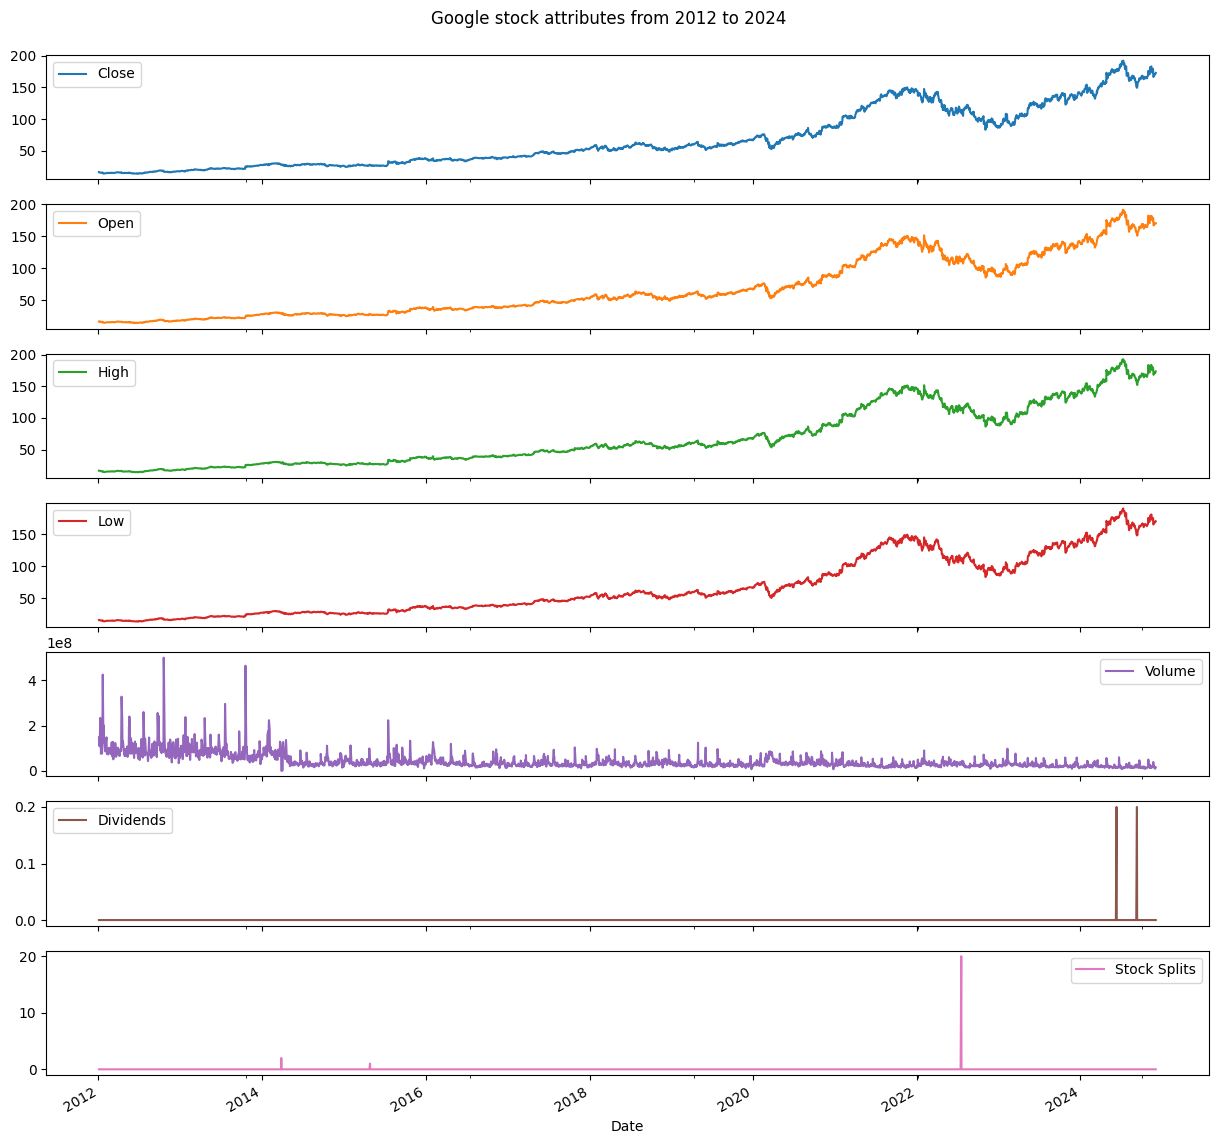

In [14]:
dataset.plot(subplots=True, figsize=(15, 15))
plt.suptitle('Google stock attributes from 2012 to 2024', y=0.91)
plt.show()

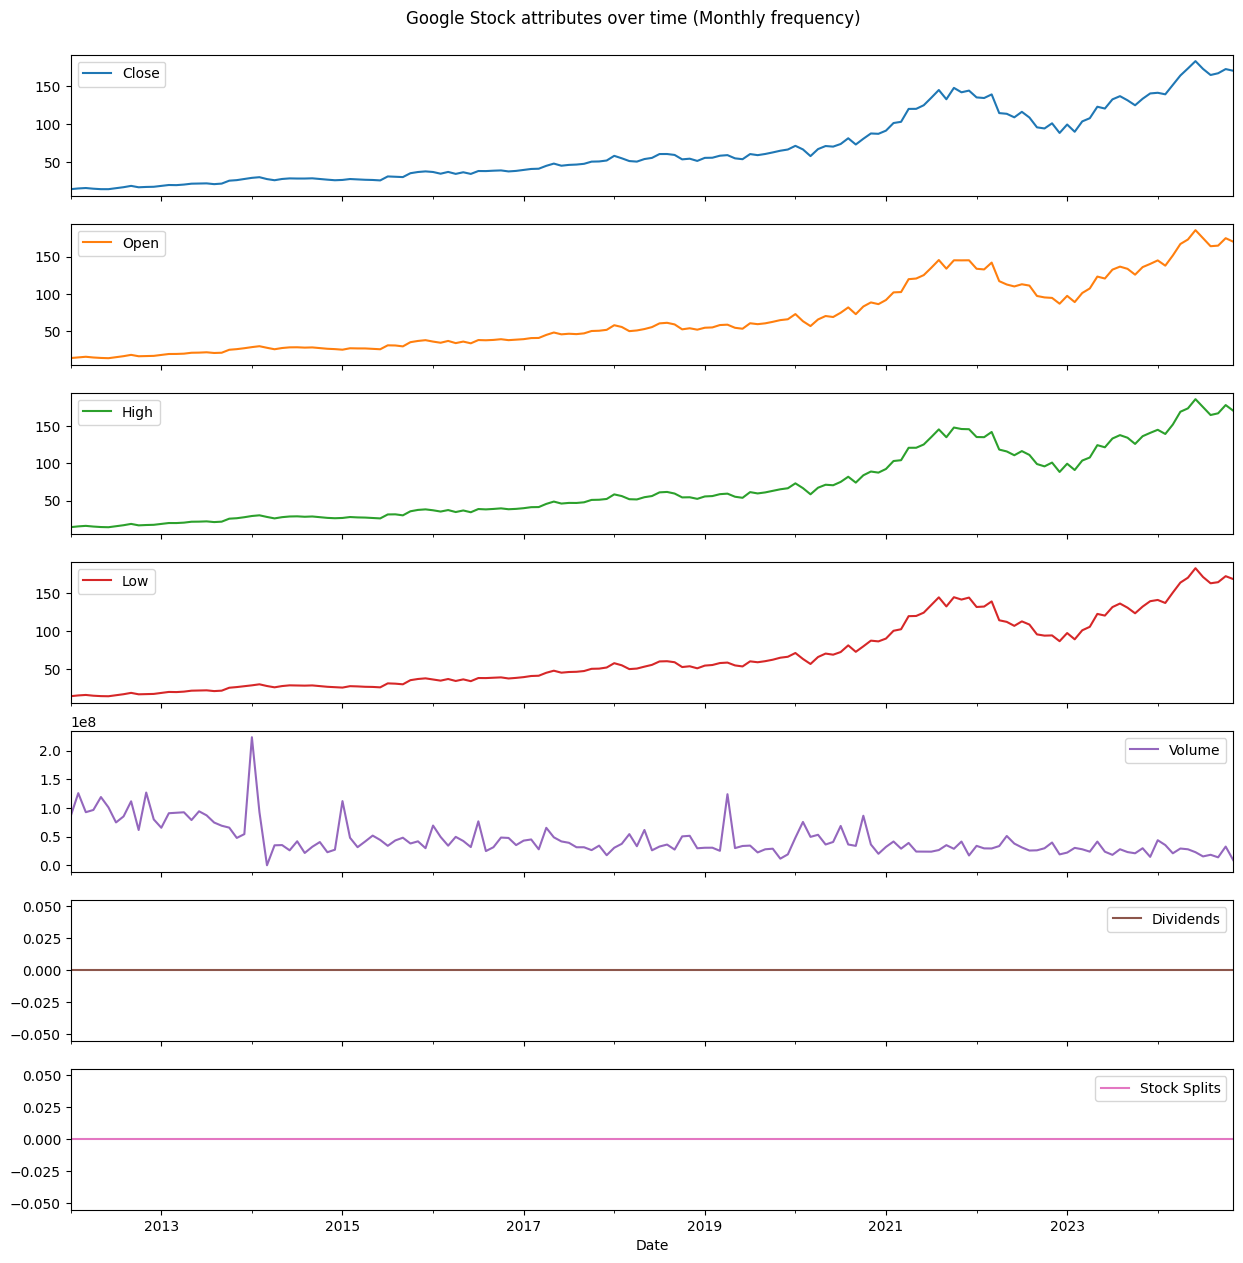

In [15]:
dataset.asfreq('M', method='ffill').plot(subplots=True, figsize=(15,15), style='-')
plt.suptitle('Google Stock attributes over time (Monthly frequency)', y=0.91)
plt.show()

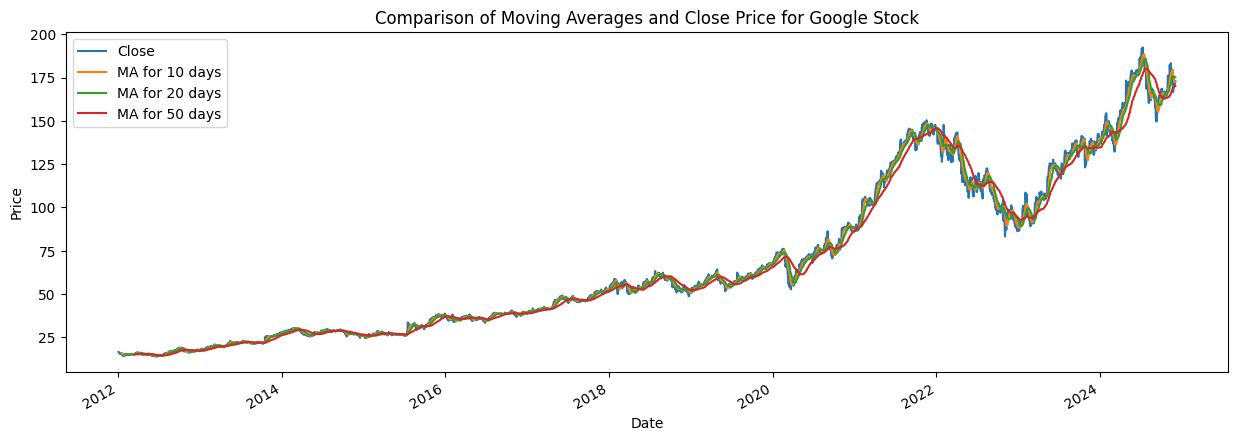

In [16]:
# Define moving average windows
ma_day = [10, 20, 50]

# Compute moving averages using a dictionary for flexibility
ma_columns = {f'MA for {ma} days': dataset['Close'].rolling(window=ma).mean() for ma in ma_day}

# Add the computed MAs to the dataset
dataset = dataset.assign(**ma_columns)

# Plot Close price and moving averages
columns_to_plot = ['Close'] + list(ma_columns.keys())
dataset[columns_to_plot].plot(figsize=(15, 5))

plt.title('Comparison of Moving Averages and Close Price for Google Stock')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

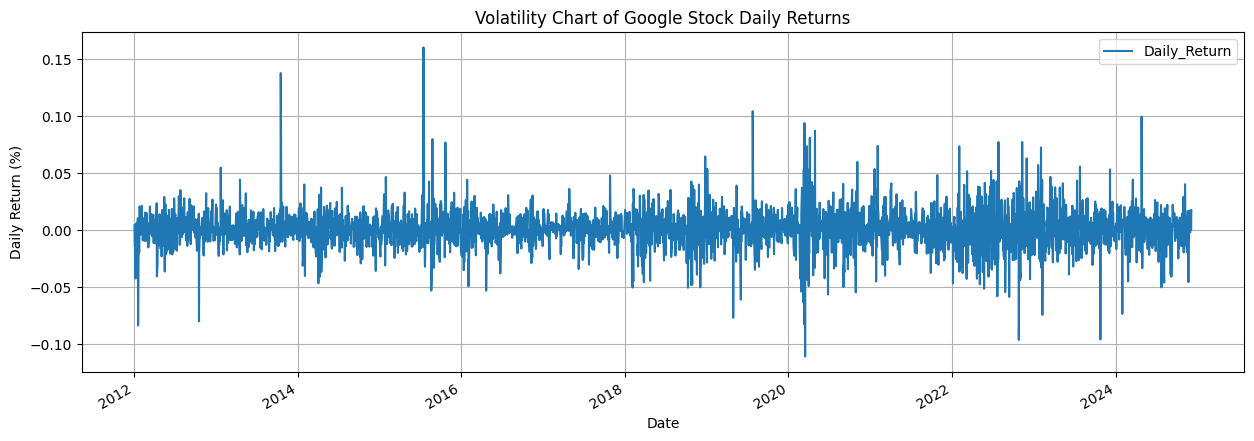

In [8]:
# Compute daily return percentage
dataset = dataset.assign(Daily_Return=lambda x: x['Close'].pct_change())

# Plot daily return
dataset['Daily_Return'].plot(figsize=(15, 5), legend=True)

# Add plot title and labels
plt.title('Volatility Chart of Google Stock Daily Returns')
plt.xlabel('Date')
plt.ylabel('Daily Return (%)')
plt.grid(True)
plt.show()

## <b>2. Data Pre-processing</b>

In [18]:
# Data Normalization
dataset_clone = dataset.copy(deep=True)
scaler = MinMaxScaler(feature_range=(0, 15))

# Apply the scaler to all relevant columns at once
columns_to_scale = ['Open', 'High', 'Low', 'Close']
dataset_clone[columns_to_scale] = scaler.fit_transform(dataset_clone[columns_to_scale])

# Extract the scaled data as a NumPy array
data = dataset_clone[columns_to_scale].values
data.shape

(3250, 4)

In [19]:
# Preparing Data for Time Series
sequence_length = 11
sequences = []
for index in range(len(data) - sequence_length + 1): 
    sequences.append(data[index: index + sequence_length])
sequences = np.array(sequences)

In [20]:
# Define percentages for validation and test sets
valid_set_size_percentage = 10
test_set_size_percentage = 10

# Calculate the test size ratio
test_ratio = test_set_size_percentage / 100
valid_ratio = valid_set_size_percentage / (100 - test_set_size_percentage)  # Adjust for remaining data after test split

# First, split off the test set
train_valid_sequences, x_test, train_valid_targets, y_test = train_test_split(
    sequences[:, :-1, :], sequences[:, -1, :], test_size=test_ratio, random_state=42, shuffle=False
)

# Then, split the remaining data into training and validation sets
x_train, x_valid, y_train, y_valid = train_test_split(
    train_valid_sequences, train_valid_targets, test_size=valid_ratio, random_state=42, shuffle=False
)

## <b>3. Predicting models</b>

### 3.1 Vanilla RNN

In [21]:
vanilla_rnn = Sequential([
    SimpleRNN(50, return_sequences=False, input_shape=(sequence_length-1, 4)),
    Dense(4)
])

vanilla_rnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 50)             │         2,750 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │           204 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,954 (11.54 KB)

 Trainable params: 2,954 (11.54 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
vanilla_rnn.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])

In [23]:
vanilla_rnn_hist = vanilla_rnn.fit(
    x_train,
    y_train,
    epochs=50,
    batch_size=64,
    validation_data=(x_valid, y_valid),
)

Epoch 1/50


I0000 00:00:1733191885.079515     157 service.cc:145] XLA service 0x79c2ac006350 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733191885.079574     157 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1733191885.079581     157 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


24/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 15.3883 - mse: 15.3883 

I0000 00:00:1733191886.409952     157 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - loss: 13.4031 - mse: 13.4031 - val_loss: 20.7340 - val_mse: 20.7340
Epoch 2/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.3437 - mse: 4.3437 - val_loss: 9.4186 - val_mse: 9.4186
Epoch 3/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.5822 - mse: 2.5822 - val_loss: 4.8643 - val_mse: 4.8643
Epoch 4/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.6248 - mse: 1.6248 - val_loss: 2.3349 - val_mse: 2.3349
Epoch 5/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0633 - mse: 1.0633 - val_loss: 1.1275 - val_mse: 1.1275
Epoch 6/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6300 - mse: 0.6300 - val_loss: 0.5894 - val_mse: 0.5894
Epoch 7/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3812 - mse: 0.3812 - val_loss: 0.2780 - val_mse: 0.2780
Epoch 8/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2518 - mse: 0.2518 - val_loss: 0.1557 - val_mse: 0.1557
Epoch 9/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1588 - mse: 0.1588

In [28]:
# Make predictions
predictions_vanilla_rnn = vanilla_rnn.predict(x_test)

# Calculate MSE
mse = mean_squared_error(y_test, predictions_vanilla_rnn)
print(f'MSE of Model Vanilla LSTM: {mse:.3f}')

# Rescale predictions back to the original scale
predictions_vanilla_rnn = scaler.inverse_transform(predictions_vanilla_rnn)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
MSE of Model Vanilla LSTM: 1.814


### 3.2 Stacked LSTM

In [30]:
stacked_lstm = Sequential()
stacked_lstm.add(LSTM(units=50, return_sequences=True, input_shape=(sequence_length-1, 4)))
stacked_lstm.add(LSTM(units=50))
stacked_lstm.add(Dropout(0.2))
stacked_lstm.add(Dense(units=4))

stacked_lstm.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 50)         │        11,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           204 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,404 (122.67 KB)

 Trainable params: 31,404 (122.67 KB)

 Non-trainable params: 0 (0.00 B)

In [31]:
stacked_lstm.compile(optimizer='adam', loss='mse', metrics=['mse'])

In [32]:
stacked_lstm_hist = stacked_lstm.fit(
    x_train,
    y_train,
    epochs=50,
    batch_size=64,
    validation_data=(x_valid, y_valid),
)

Epoch 1/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 15.2179 - mse: 15.2179 - val_loss: 14.2243 - val_mse: 14.2243
Epoch 2/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.1536 - mse: 3.1536 - val_loss: 2.8096 - val_mse: 2.8096
Epoch 3/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.1837 - mse: 1.1837 - val_loss: 0.6917 - val_mse: 0.6917
Epoch 4/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6297 - mse: 0.6297 - val_loss: 0.5187 - val_mse: 0.5187
Epoch 5/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4519 - mse: 0.4519 - val_loss: 0.2474 - val_mse: 0.2474
Epoch 6/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3175 - mse: 0.3175 - val_loss: 0.2563 - val_mse: 0.2563
Epoch 7/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2371 - mse: 0.2371 - val_loss: 0.1400 - val_mse: 0.1400
Epoch 8/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2176 - mse: 0.2176 - val_loss: 0.1342 - val_mse: 0.1342
Epoch 9/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1861 - 

In [34]:
# Make predictions
prediction_stacked_lstm = stacked_lstm.predict(x_test)

# Calculate MSE
mse = mean_squared_error(y_test, prediction_stacked_lstm)
print(f'MSE of Model Stacked LSTM: {mse:.3f}')

# Rescale predictions back to the original scale
prediction_stacked_lstm = scaler.inverse_transform(prediction_stacked_lstm)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
MSE of Model Stacked LSTM: 0.847


### 3.3 Gated Recurrent Unit (GRU)

In [36]:
gru = Sequential([
    GRU(50, return_sequences=False, input_shape=(sequence_length-1, 4)),
    Dense(4)
])

gru.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 50)             │         8,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           204 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,604 (33.61 KB)

 Trainable params: 8,604 (33.61 KB)

 Non-trainable params: 0 (0.00 B)

In [37]:
# Compile model
gru.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])

In [38]:
# Train model
gru_hist = gru.fit(x_train, 
                   y_train, 
                   epochs=50, 
                   batch_size=64, 
                   validation_data=(x_valid, y_valid))

Epoch 1/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 14.5451 - mse: 14.5451 - val_loss: 23.7477 - val_mse: 23.7477
Epoch 2/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.4761 - mse: 5.4761 - val_loss: 10.3654 - val_mse: 10.3654
Epoch 3/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.8969 - mse: 2.8969 - val_loss: 4.0331 - val_mse: 4.0331
Epoch 4/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.4631 - mse: 1.4631 - val_loss: 1.5983 - val_mse: 1.5983
Epoch 5/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9063 - mse: 0.9063 - val_loss: 0.6114 - val_mse: 0.6114
Epoch 6/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4875 - mse: 0.4875 - val_loss: 0.2531 - val_mse: 0.2531
Epoch 7/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3063 - mse: 0.3063 - val_loss: 0.1201 - val_mse: 0.1201
Epoch 8/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1961 - mse: 0.1961 - val_loss: 0.0854 - val_mse: 0.0854
Epoch 9/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1161 -

In [40]:
prediction_gru = gru.predict(x_test)
# Calculate MSE
mse = mean_squared_error(y_test, prediction_gru)
print(f'MSE of GRU: {mse:.3f}')

prediction_gru = scaler.inverse_transform(prediction_gru)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
MSE of GRU: 1.934


In [42]:
# Save the entire model to a HDF5 file.
stacked_lstm.save('/kaggle/working/stacked_lstm_model.h5')

### 3.4 Hyperparameter tuning (Stacked LSTM)

In [43]:
# Load the model with custom_objects
final_model = load_model(
    '/kaggle/working/stacked_lstm_model.h5',
    custom_objects={'mse': MeanSquaredError()}
)

# Verify the model
final_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 50)         │        11,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           204 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,406 (122.68 KB)

 Trainable params: 31,404 (122.67 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [44]:
def objective(trial, model):
    # Hyperparameters to tune
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    epochs = trial.suggest_int('epochs', 30, 100)
    
    # Clone the model to avoid modifying the original
    tuning_model = tf.keras.models.clone_model(model)
    tuning_model.set_weights(model.get_weights())
    
    # Recompile the model with tuned learning rate
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    tuning_model.compile(optimizer=optimizer, loss='mse', metrics=['mse'])
    
    # Train the model with tuned hyperparameters
    hyper_history = tuning_model.fit(
        x_train,
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_valid, y_valid),
        verbose=0
    )
    
    # Predict and calculate validation loss
    predictions = tuning_model.predict(x_valid)
    val_loss = mean_squared_error(y_valid, predictions)
    
    return val_loss

# Create an Optuna study
study = optuna.create_study(direction='minimize')
study.optimize(lambda trial: objective(trial, final_model), n_trials=50)

# Print best trial details
print('Number of finished trials:', len(study.trials))
print('Best trial:')
trial = study.best_trial
print('  Value (validation loss):', trial.value)
print('  Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')

# Retrain the model with best hyperparameters
best_model = tf.keras.models.clone_model(final_model)
best_model.set_weights(stacked_lstm.get_weights())
best_optimizer = tf.keras.optimizers.Adam(learning_rate=trial.params['learning_rate'])
best_model.compile(optimizer=best_optimizer, loss='mse', metrics=['mse'])

# Fit with best hyperparameters
best_model.fit(
    x_train,
    y_train,
    epochs=trial.params['epochs'],
    batch_size=trial.params['batch_size'],
    validation_data=(x_valid, y_valid)
)

# Predict and calculate MSE on test set
prediction_best_lstm = best_model.predict(x_test)
prediction_best_lstm = scaler.inverse_transform(prediction_best_lstm)

# Save the best model
best_model.save('best_stacked_lstm.h5')

[I 2024-12-03 02:37:51,997] A new study created in memory with name: no-name-865ff103-80d1-4659-869c-58cd29938e0d


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


[I 2024-12-03 02:38:04,598] Trial 0 finished with value: 0.03183033645116457 and parameters: {'learning_rate': 0.007265325504958788, 'batch_size': 128, 'epochs': 64}. Best is trial 0 with value: 0.03183033645116457.


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


[I 2024-12-03 02:38:18,468] Trial 1 finished with value: 0.032434948475212166 and parameters: {'learning_rate': 0.0009732280668270608, 'batch_size': 128, 'epochs': 75}. Best is trial 0 with value: 0.03183033645116457.


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


[I 2024-12-03 02:38:32,583] Trial 2 finished with value: 0.27943802065219026 and parameters: {'learning_rate': 0.0037050789099087557, 'batch_size': 128, 'epochs': 78}. Best is trial 0 with value: 0.03183033645116457.


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


[I 2024-12-03 02:39:02,287] Trial 3 finished with value: 0.04625047011896357 and parameters: {'learning_rate': 0.0008785132724685016, 'batch_size': 32, 'epochs': 66}. Best is trial 0 with value: 0.03183033645116457.


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


[I 2024-12-03 02:39:15,223] Trial 4 finished with value: 0.16684502263570958 and parameters: {'learning_rate': 0.003581927244456991, 'batch_size': 64, 'epochs': 41}. Best is trial 0 with value: 0.03183033645116457.


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


[I 2024-12-03 02:39:32,211] Trial 5 finished with value: 0.03588913199991628 and parameters: {'learning_rate': 0.0007646314780853419, 'batch_size': 32, 'epochs': 36}. Best is trial 0 with value: 0.03183033645116457.


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


[I 2024-12-03 02:39:46,823] Trial 6 finished with value: 0.032356270483040905 and parameters: {'learning_rate': 0.0012895400360555607, 'batch_size': 128, 'epochs': 80}. Best is trial 0 with value: 0.03183033645116457.


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


[I 2024-12-03 02:40:04,374] Trial 7 finished with value: 0.1521914885545236 and parameters: {'learning_rate': 0.0039907201253838905, 'batch_size': 64, 'epochs': 57}. Best is trial 0 with value: 0.03183033645116457.


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


[I 2024-12-03 02:40:44,578] Trial 8 finished with value: 0.05024789843518779 and parameters: {'learning_rate': 0.00014697277902073663, 'batch_size': 32, 'epochs': 91}. Best is trial 0 with value: 0.03183033645116457.


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


[I 2024-12-03 02:41:02,181] Trial 9 finished with value: 0.049588617647642684 and parameters: {'learning_rate': 0.00203577356752629, 'batch_size': 128, 'epochs': 100}. Best is trial 0 with value: 0.03183033645116457.


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


[I 2024-12-03 02:41:12,690] Trial 10 finished with value: 0.048918647635251444 and parameters: {'learning_rate': 0.00944407417140868, 'batch_size': 128, 'epochs': 54}. Best is trial 0 with value: 0.03183033645116457.


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


[I 2024-12-03 02:41:27,606] Trial 11 finished with value: 0.03501643314873834 and parameters: {'learning_rate': 0.00022473792083197296, 'batch_size': 128, 'epochs': 81}. Best is trial 0 with value: 0.03183033645116457.


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


[I 2024-12-03 02:41:40,043] Trial 12 finished with value: 0.03453218793443481 and parameters: {'learning_rate': 0.009950275667098399, 'batch_size': 128, 'epochs': 66}. Best is trial 0 with value: 0.03183033645116457.


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


[I 2024-12-03 02:41:51,147] Trial 13 finished with value: 0.034314928019582476 and parameters: {'learning_rate': 0.0003873467128482822, 'batch_size': 128, 'epochs': 56}. Best is trial 0 with value: 0.03183033645116457.


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


[I 2024-12-03 02:42:06,824] Trial 14 finished with value: 0.044769020589467606 and parameters: {'learning_rate': 0.001946939938018522, 'batch_size': 128, 'epochs': 88}. Best is trial 0 with value: 0.03183033645116457.


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


[I 2024-12-03 02:42:22,033] Trial 15 finished with value: 0.04940586057832433 and parameters: {'learning_rate': 0.0003596350577204197, 'batch_size': 64, 'epochs': 46}. Best is trial 0 with value: 0.03183033645116457.


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


[I 2024-12-03 02:42:35,501] Trial 16 finished with value: 0.035625445120749145 and parameters: {'learning_rate': 0.001962627470775165, 'batch_size': 128, 'epochs': 73}. Best is trial 0 with value: 0.03183033645116457.


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


[I 2024-12-03 02:42:50,909] Trial 17 finished with value: 0.0625965365066798 and parameters: {'learning_rate': 0.006072081855591339, 'batch_size': 128, 'epochs': 86}. Best is trial 0 with value: 0.03183033645116457.


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


[I 2024-12-03 02:43:34,820] Trial 18 finished with value: 0.03562837506740099 and parameters: {'learning_rate': 0.00046281525412198376, 'batch_size': 32, 'epochs': 99}. Best is trial 0 with value: 0.03183033645116457.


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


[I 2024-12-03 02:43:55,476] Trial 19 finished with value: 0.03110836665055581 and parameters: {'learning_rate': 0.0013862816035861076, 'batch_size': 64, 'epochs': 71}. Best is trial 19 with value: 0.03110836665055581.


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


[I 2024-12-03 02:44:15,464] Trial 20 finished with value: 0.13393465234781599 and parameters: {'learning_rate': 0.005128836919396354, 'batch_size': 64, 'epochs': 69}. Best is trial 19 with value: 0.03110836665055581.


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


[I 2024-12-03 02:44:33,335] Trial 21 finished with value: 0.06063203425801199 and parameters: {'learning_rate': 0.0015672698949828, 'batch_size': 64, 'epochs': 60}. Best is trial 19 with value: 0.03110836665055581.


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


[I 2024-12-03 02:44:54,420] Trial 22 finished with value: 0.054269687182437396 and parameters: {'learning_rate': 0.0012945065219452407, 'batch_size': 64, 'epochs': 73}. Best is trial 19 with value: 0.03110836665055581.


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


[I 2024-12-03 02:45:09,521] Trial 23 finished with value: 0.04829506830424473 and parameters: {'learning_rate': 0.0006431625756949155, 'batch_size': 64, 'epochs': 49}. Best is trial 19 with value: 0.03110836665055581.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


[I 2024-12-03 02:45:25,204] Trial 24 finished with value: 0.035134105067987385 and parameters: {'learning_rate': 0.00259427978174349, 'batch_size': 128, 'epochs': 82}. Best is trial 19 with value: 0.03110836665055581.


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


[I 2024-12-03 02:45:43,852] Trial 25 finished with value: 0.05330267804483283 and parameters: {'learning_rate': 0.0012579440104959327, 'batch_size': 64, 'epochs': 61}. Best is trial 19 with value: 0.03110836665055581.


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


[I 2024-12-03 02:46:00,673] Trial 26 finished with value: 0.03293685565037313 and parameters: {'learning_rate': 0.0006033134106494843, 'batch_size': 128, 'epochs': 93}. Best is trial 19 with value: 0.03110836665055581.


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


[I 2024-12-03 02:46:14,023] Trial 27 finished with value: 0.04180352722397919 and parameters: {'learning_rate': 0.00011245624003782411, 'batch_size': 128, 'epochs': 71}. Best is trial 19 with value: 0.03110836665055581.


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


[I 2024-12-03 02:46:32,695] Trial 28 finished with value: 0.04276951147541371 and parameters: {'learning_rate': 0.00025423556848819544, 'batch_size': 64, 'epochs': 63}. Best is trial 19 with value: 0.03110836665055581.


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


[I 2024-12-03 02:47:07,565] Trial 29 finished with value: 0.03281875624142096 and parameters: {'learning_rate': 0.006605229609855286, 'batch_size': 32, 'epochs': 78}. Best is trial 19 with value: 0.03110836665055581.


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


[I 2024-12-03 02:47:17,735] Trial 30 finished with value: 0.05387750171205226 and parameters: {'learning_rate': 0.0010667657670611255, 'batch_size': 128, 'epochs': 51}. Best is trial 19 with value: 0.03110836665055581.


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


[I 2024-12-03 02:47:31,868] Trial 31 finished with value: 0.051199926988410915 and parameters: {'learning_rate': 0.0029062364261066933, 'batch_size': 128, 'epochs': 78}. Best is trial 19 with value: 0.03110836665055581.


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


[I 2024-12-03 02:47:45,959] Trial 32 finished with value: 0.05529264860934792 and parameters: {'learning_rate': 0.0009502116449912777, 'batch_size': 128, 'epochs': 75}. Best is trial 19 with value: 0.03110836665055581.


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


[I 2024-12-03 02:47:58,339] Trial 33 finished with value: 0.07097762651700086 and parameters: {'learning_rate': 0.0016062210711580724, 'batch_size': 128, 'epochs': 65}. Best is trial 19 with value: 0.03110836665055581.


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


[I 2024-12-03 02:48:11,265] Trial 34 finished with value: 0.040074903863535065 and parameters: {'learning_rate': 0.0006854760917018779, 'batch_size': 128, 'epochs': 68}. Best is trial 19 with value: 0.03110836665055581.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


[I 2024-12-03 02:48:49,770] Trial 35 finished with value: 0.03192360845036312 and parameters: {'learning_rate': 0.003169150113123512, 'batch_size': 32, 'epochs': 83}. Best is trial 19 with value: 0.03110836665055581.


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


[I 2024-12-03 02:49:26,869] Trial 36 finished with value: 0.04545915223712436 and parameters: {'learning_rate': 0.004625437354391153, 'batch_size': 32, 'epochs': 81}. Best is trial 19 with value: 0.03110836665055581.


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


[I 2024-12-03 02:50:06,115] Trial 37 finished with value: 0.06467291537644457 and parameters: {'learning_rate': 0.003035664406034554, 'batch_size': 32, 'epochs': 87}. Best is trial 19 with value: 0.03110836665055581.


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


[I 2024-12-03 02:50:40,700] Trial 38 finished with value: 0.04236776007710719 and parameters: {'learning_rate': 0.007275569052464478, 'batch_size': 32, 'epochs': 77}. Best is trial 19 with value: 0.03110836665055581.


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


[I 2024-12-03 02:51:23,040] Trial 39 finished with value: 0.08207527414647808 and parameters: {'learning_rate': 0.003917018238379779, 'batch_size': 32, 'epochs': 95}. Best is trial 19 with value: 0.03110836665055581.


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


[I 2024-12-03 02:52:00,810] Trial 40 finished with value: 0.040441189651906115 and parameters: {'learning_rate': 0.002592985513935882, 'batch_size': 32, 'epochs': 84}. Best is trial 19 with value: 0.03110836665055581.


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


[I 2024-12-03 02:52:14,128] Trial 41 finished with value: 0.0592548600549566 and parameters: {'learning_rate': 0.0009056186765869674, 'batch_size': 128, 'epochs': 71}. Best is trial 19 with value: 0.03110836665055581.


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


[I 2024-12-03 02:52:24,863] Trial 42 finished with value: 0.23469334366171607 and parameters: {'learning_rate': 0.0012985015731412182, 'batch_size': 64, 'epochs': 32}. Best is trial 19 with value: 0.03110836665055581.


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


[I 2024-12-03 02:52:40,956] Trial 43 finished with value: 0.11367021777793997 and parameters: {'learning_rate': 0.008193000441039587, 'batch_size': 128, 'epochs': 90}. Best is trial 19 with value: 0.03110836665055581.


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


[I 2024-12-03 02:53:14,387] Trial 44 finished with value: 0.13205240601778645 and parameters: {'learning_rate': 0.0022401646802480955, 'batch_size': 32, 'epochs': 75}. Best is trial 19 with value: 0.03110836665055581.


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


[I 2024-12-03 02:53:29,561] Trial 45 finished with value: 0.035996764470150155 and parameters: {'learning_rate': 0.0016228340468569026, 'batch_size': 128, 'epochs': 81}. Best is trial 19 with value: 0.03110836665055581.


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


[I 2024-12-03 02:53:42,258] Trial 46 finished with value: 0.05776496534751321 and parameters: {'learning_rate': 0.0007815699407936822, 'batch_size': 128, 'epochs': 67}. Best is trial 19 with value: 0.03110836665055581.


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


[I 2024-12-03 02:53:59,899] Trial 47 finished with value: 0.06451558621030333 and parameters: {'learning_rate': 0.0035067412199112414, 'batch_size': 64, 'epochs': 58}. Best is trial 19 with value: 0.03110836665055581.


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


[I 2024-12-03 02:54:16,622] Trial 48 finished with value: 0.06940485669000353 and parameters: {'learning_rate': 0.005061439540474043, 'batch_size': 128, 'epochs': 84}. Best is trial 19 with value: 0.03110836665055581.


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


[I 2024-12-03 02:54:46,249] Trial 49 finished with value: 0.031059082838997096 and parameters: {'learning_rate': 0.0004956006500788101, 'batch_size': 32, 'epochs': 64}. Best is trial 49 with value: 0.031059082838997096.


Number of finished trials: 50
Best trial:
  Value (validation loss): 0.031059082838997096
  Params: 
    learning_rate: 0.0004956006500788101
    batch_size: 32
    epochs: 64
Epoch 1/64
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1325 - mse: 0.1325 - val_loss: 0.0513 - val_mse: 0.0513
Epoch 2/64
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1375 - mse: 0.1375 - val_loss: 0.0446 - val_mse: 0.0446
Epoch 3/64
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1080 - mse: 0.1080 - val_loss: 0.0644 - val_mse: 0.0644
Epoch 4/64
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1223 - mse: 0.1223 - val_loss: 0.0747 - val_mse: 0.0747
Epoch 5/64
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1156 - mse: 0.1156 - val_loss: 0.1138 - val_mse: 0.1138
Epoch 6/64
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1299 - mse: 0.1299 - val_loss: 0.1278 - val_mse: 0.1278
Epoch 7/64
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1208 - mse: 0.1208 - val_loss: 0.0523 - val_mse: 0.0523
Epoch 8/64
8

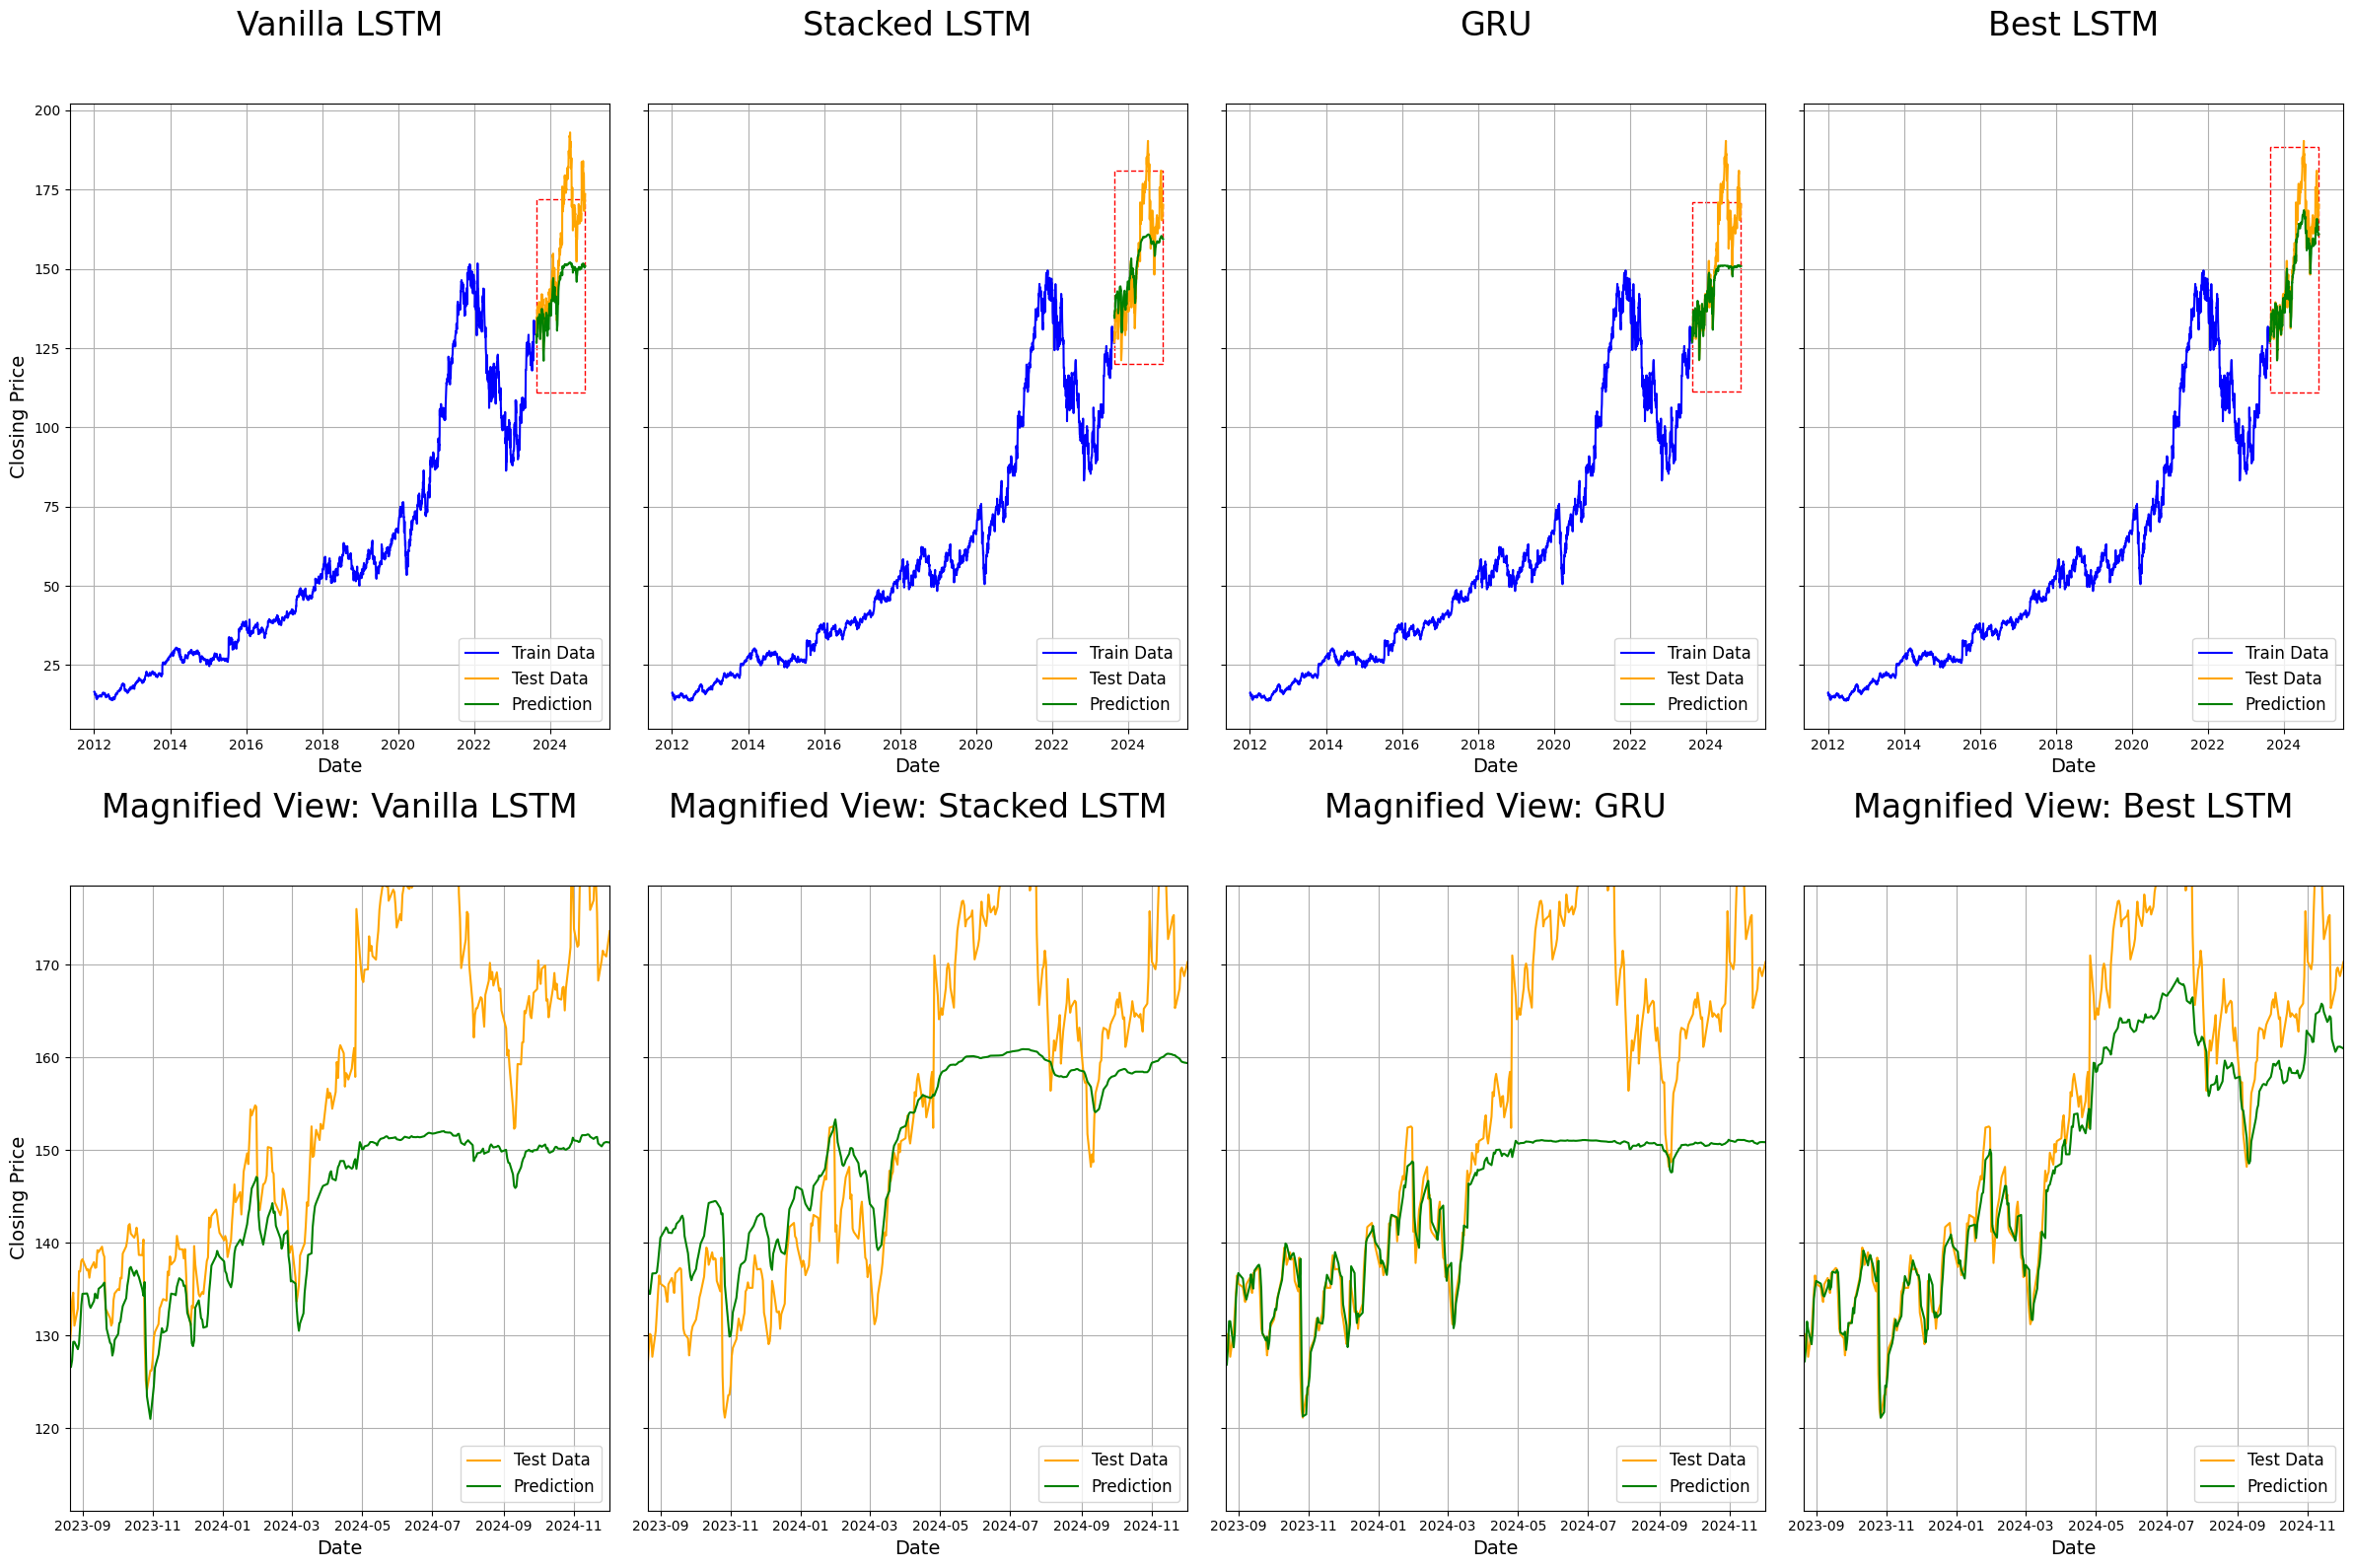

In [85]:
plot_grouped_predictions(
    predictions_list=[predictions_vanilla_rnn, prediction_stacked_lstm, prediction_gru, prediction_best_lstm],
    indices=[2, 3, 3, 3],
    data_source=dataset,
    y_test=y_test,
    titles=['Vanilla LSTM', 'Stacked LSTM', 'GRU', 'Best LSTM']
)

### 3.5 Plotting

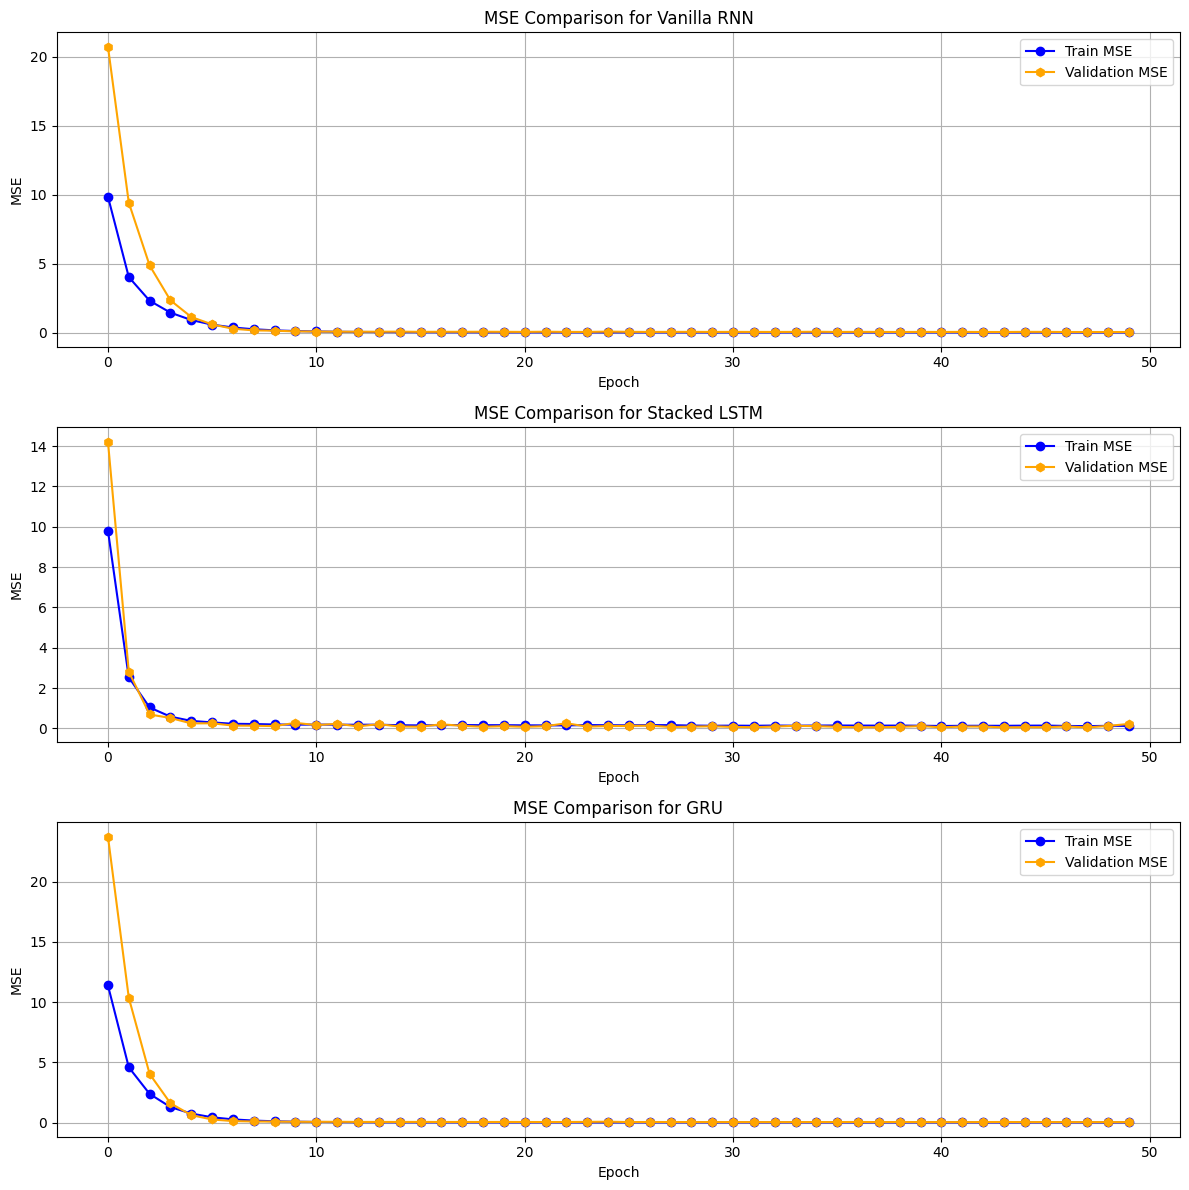

In [48]:
plot_mse_comparison(
    models_histories=[vanilla_rnn_hist, stacked_lstm_hist, gru_hist],
    model_names=['Vanilla RNN', 'Stacked LSTM', 'GRU']
)

## <b>4. Predicting the next 10 days</b>

In [51]:
prediction_best_model = best_model.predict(x_test)
# Calculate MSE
mse = mean_squared_error(y_test, prediction_best_model)
print(f'MSE of Hyperparameter-tuning Stacked LSTM: {mse:.3f}')

prediction_best_model = scaler.inverse_transform(prediction_best_model)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
MSE of Hyperparameter-tuning Stacked LSTM: 0.500


In [52]:
# Predict the next 10 days of stock prices

# Extract the last sequence of historical data for prediction
recent_sequence = sequences[-1:, 1:, :]

# Define the number of days to predict
NUM_PREDICTIONS = 10

# Predict stock prices iteratively for the next NUM_PREDICTIONS days
for day in range(NUM_PREDICTIONS):
    # Predict the next time step
    next_prediction = best_model.predict(recent_sequence, verbose=0)
    # Append the prediction to the recent sequence
    recent_sequence = np.concatenate((recent_sequence, next_prediction[np.newaxis, :, :]), axis=1)
    # Remove the oldest time step to maintain sequence length
    recent_sequence = recent_sequence[:, 1:, :]

# Rescale the predictions back to their original values
predicted_prices = scaler.inverse_transform(recent_sequence.reshape(NUM_PREDICTIONS, 4))

# Create a DataFrame to store the predicted stock prices
predicted_df = pd.DataFrame(
    data=predicted_prices, 
    columns=['Open', 'High', 'Low', 'Close']
)

predicted_df

,Open,High,Low,Close
0,161.386415,162.963187,159.831525,161.580509
1,157.368076,158.989561,155.792128,157.547134
2,154.366807,155.992866,152.783129,154.531336
3,151.880630,153.502688,150.296630,152.038910
4,149.664985,151.278984,148.084778,149.820809
5,147.626399,149.229021,146.053535,147.781150
6,145.727426,147.317047,144.164841,145.881660
7,143.943689,145.519843,142.393619,144.097745
8,142.258119,143.820982,140.722271,142.412324
9,140.663614,142.214957,139.142805,140.818587
